In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
#Hyperparameters
seed = 999
dataroot = "/content/drive/MyDrive/untitled folder/"
workers = 2
batch_size = 128
img_dim = 28
channels = 1
latentz = 100
num_epochs = 5
lr = 2e-4
beta1 = 0.5
gpus = 1 if torch.cuda.is_available() else 0
nfg = 28
nfd = 64
device = torch.device("cuda:0" if gpus else "cpu")

#Pre requisites
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latentz, 1, 1, device = device)

real_target = 1.
fake_target = 0.

transforms = T.Compose([
    T.Resize(img_dim),
    T.CenterCrop(img_dim),
    T.ToTensor(),
    T.Normalize(mean = 0.5, std = 0.5),
])

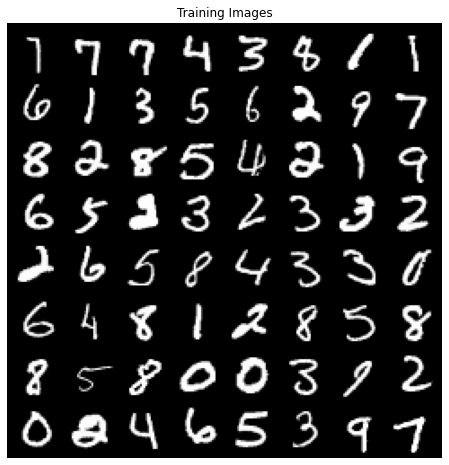

In [ ]:
dataset = dset.MNIST(root = "dataset/", transform = transforms)

dataloader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

#Plotting some training images
batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding = 2, normalize = True).cpu(), (1, 2, 0)))
#plt.show() 

In [ ]:
#Weights initialization from Normal Distribution, mean = 0, Standard deviation = 0.02
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0.0)

def conv_block_gen(in_channels, out_channels, kernel_size, stride, padding, bias = True):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True),
    )
    return layers

def conv_bloc_dis(in_channels, out_channels, kernel_size, stride, padding, bias = True, alpha = 0.2):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(alpha, inplace = True)
    )
    return layers

#The generator constructs an image from an arbitrary input space
class Generator(nn.Module):
    def __init__(self, gpus):
        super(Generator, self).__init__()
        self.gpus = gpus
        self.layers = nn.Sequential(
            # input is Z, going into a convolution
            # nn.ConvTranspose2d(latentz, nfg * 8, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(nfg * 8),
            # nn.ReLU(True),
            # state size. (nfg*8) x 4 x 4
            # nn.ConvTranspose2d(latentz, nfg * 4, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nfg * 4),
            # nn.ReLU(True),
            # state size. (nfg*4) x 8 x 8
            nn.ConvTranspose2d(latentz, nfg * 2, 7, 1, 0, bias=False),
            nn.BatchNorm2d(nfg * 2),
            nn.ReLU(True),
            # state size. (nfg*2) x 7 x 7
            nn.ConvTranspose2d( nfg * 2, nfg, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg),
            nn.ReLU(True),
            # state size. (nfg) x 14 x 14
            nn.ConvTranspose2d(nfg, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (channels) x 28 x 28
        )

    def forward(self, x):
        return self.layers(x)

#Discriminator classifies the image generated by the Generator as fake or real
class Discriminator(nn.Module):
    def __init__(self, gpus):
        super(Discriminator, self).__init__()
        self.gpus = gpus
        self.layers = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(channels, nfd, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nfd) x 14 x 14
            nn.Conv2d(nfd, nfd * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(nfd * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nfd * 2, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def Create_DCObject(DCstring, gpus):
    DC = None
    if DCstring.lower() == 'gen':
        DC = Generator(gpus).to(device)
    elif DCstring.lower() == 'dis':
        DC = Discriminator(gpus).to(device)
    else: return None

    if (device.type == 'cuda') and (gpus > 1):
        DC = nn.DataParallel(DC, list(range(gpus)))
    
    DC.apply(init_weights)
    return DC

def plot_prog(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

DCGen = Create_DCObject('gen', gpus)
DCDis = Create_DCObject('dis', gpus)

# print(DCGen)
# print(DCDis)

optimizerG = optim.Adam(DCGen.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerD = optim.Adam(DCDis.parameters(), lr = lr, betas = (beta1, 0.999))

#Training Loop

img_list = []
G_losses = []
D_losses = []
iters = 0


In [ ]:
num_epochs = 50

In [ ]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader, 0):   #batch.shape = [2,]
        # print(i)
        #First, we compute the loss of the discriminator's ability to classify all the data images as real
        DCDis.zero_grad()
        features = batch[0].to(device)          #shape = [128, 1, 28, 28]
        b_size = features.size(0)               #b_size = 128

        r_target = torch.full((b_size, ), real_target, dtype = torch.float).to(device) #shape = 128
        r_output = DCDis(features).view(-1)       #Sigmoid output of shape [128]

        real_loss = criterion(r_output, r_target)   #BCELoss on preds and targets
        real_loss.backward()                        #Backpropagation
        D_r = r_output.mean().item()                #Computing gradients

        #Now, we give it a noise, generate fake images from the noise using the generator and train the discriminator to classify them as real or fake
        noise = torch.randn(b_size, latentz, 1, 1, device = device)

        fake = DCGen(noise)
        f_target = torch.full((b_size, ), fake_target, dtype = torch.float, device = device)
        f_output = DCDis(fake.detach()).view(-1) #why did we use detach? this is because while backprop. everything will get changed which we do not want to. We do not want to change the fake predictions

        fake_loss = criterion(f_output, f_target)
        fake_loss.backward()
        D_G_z1 = f_output.mean().item()

        lossD = real_loss + fake_loss
        optimizerD.step()

        #Now we work upon the Generator
        DCGen.zero_grad()

        output = DCDis(fake).view(-1)
        lossG = criterion(output, r_target)
        lossG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'% (epoch, num_epochs, i, len(dataloader),lossD.item(), lossG.item(), D_r, D_G_z1, D_G_z2))

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and i == len(dataloader) - 1):
            with torch.no_grad():
                fake = DCGen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))

        iters += 1

[0/50][0/469]	Loss_D: 0.3195	Loss_G: 4.0517	D(x): 0.9394	D(G(z)): 0.1870 / 0.0399
[0/50][50/469]	Loss_D: 0.2168	Loss_G: 3.3278	D(x): 0.8821	D(G(z)): 0.0648 / 0.0840
[0/50][100/469]	Loss_D: 0.1660	Loss_G: 3.5345	D(x): 0.9211	D(G(z)): 0.0628 / 0.0632
[0/50][150/469]	Loss_D: 0.3302	Loss_G: 4.6904	D(x): 0.9786	D(G(z)): 0.2305 / 0.0164
[0/50][200/469]	Loss_D: 0.4516	Loss_G: 5.1572	D(x): 0.9652	D(G(z)): 0.2707 / 0.0142
[0/50][250/469]	Loss_D: 0.2385	Loss_G: 3.3916	D(x): 0.8504	D(G(z)): 0.0284 / 0.0646
[0/50][300/469]	Loss_D: 0.2415	Loss_G: 2.8913	D(x): 0.8434	D(G(z)): 0.0306 / 0.1053
[0/50][350/469]	Loss_D: 0.4167	Loss_G: 1.5660	D(x): 0.7574	D(G(z)): 0.0369 / 0.3298
[0/50][400/469]	Loss_D: 1.2968	Loss_G: 1.4229	D(x): 0.4238	D(G(z)): 0.0038 / 0.3787
[0/50][450/469]	Loss_D: 0.3739	Loss_G: 4.8021	D(x): 0.9647	D(G(z)): 0.2419 / 0.0165
[1/50][0/469]	Loss_D: 0.1653	Loss_G: 3.2144	D(x): 0.9334	D(G(z)): 0.0737 / 0.0733
[1/50][50/469]	Loss_D: 0.2321	Loss_G: 3.8011	D(x): 0.9555	D(G(z)): 0.1440 / 0.050

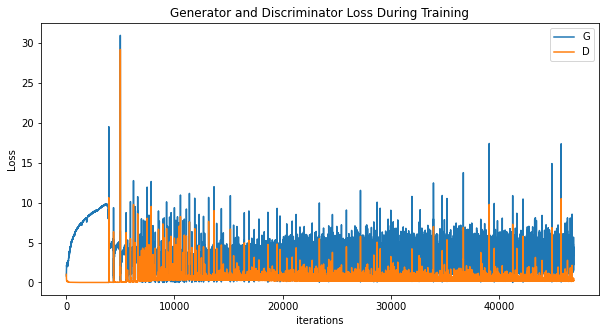

In [ ]:
plot_prog(G_losses, D_losses)

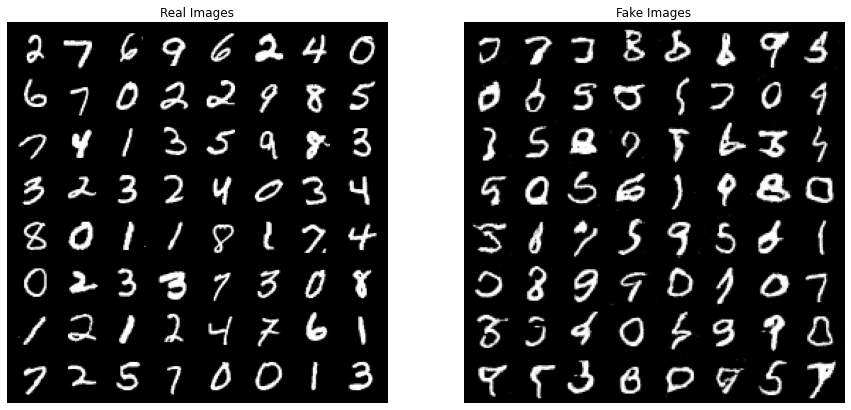

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
print("Model's state_dict:")
for param_tensor in DCDis.state_dict():
    print(param_tensor, "\t", DCDis.state_dict()[param_tensor].size())

Model's state_dict:
layers.0.weight 	 torch.Size([64, 1, 3, 3])
layers.2.weight 	 torch.Size([128, 64, 3, 3])
layers.3.weight 	 torch.Size([128])
layers.3.bias 	 torch.Size([128])
layers.3.running_mean 	 torch.Size([128])
layers.3.running_var 	 torch.Size([128])
layers.3.num_batches_tracked 	 torch.Size([])
layers.5.weight 	 torch.Size([1, 128, 7, 7])


In [ ]:
print("Optimizer's state_dict:")
for var_name in optimizerD.state_dict():
    print(var_name, "\t", optimizerD.state_dict()[var_name])

In [ ]:
Dis = '100dis.pth'
Gen = '100gen.pth'

In [ ]:
torch.save(DCDis.state_dict(), dataroot + Dis)

In [ ]:
torch.save(DCGen.state_dict(), dataroot + Gen)